In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [2]:
Sigma_x = np.matrix([[0, 1], [1, 0]])
Sigma_y = np.matrix([[0, -1j], [1j, 0]])
Sigma_z = np.matrix([[1, 0], [0, -1]])
Sigma_plus = (Sigma_x +1j*Sigma_y)/2
Sigma_minus = Sigma_plus.getH()

In [3]:
def Enlarge_Matrix_site_j(j, N, matrix):
    # I⊗...⊗I⊗M⊗I...⊗I: Convert local operators into global operators.
    # j: site, starts in 0.
    
    M = np.eye(len(matrix))
    if j == 0: M = matrix
    
    for i in range(1,N):
        if i == j: M = np.kron(M, matrix)
        else: M = np.kron(M, np.eye(len(matrix)))        

    return M

def Correlation_Matrix_i_Matrix_j(i,j,N,matrix_i, matrix_j):
    # I⊗...⊗I⊗M⊗I...⊗I⊗M⊗I⊗I...⊗I

    M = np.eye(len(matrix_i))
    
    if j == 0: M = matrix_j
    elif i == 0: M = matrix_i
    
    for k in range(1,N):
        if k == j: M = np.kron(M, matrix_j)
        elif k == i: M = np.kron(M, matrix_i)
        else: M = np.kron(M, np.eye(len(matrix_i)))        

    return M

def S_Term(N, cte_list, SigmaMatrix):
    # I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I: Sigma can be Sigmax, Sigmay or Sigmaz.
    # cte_list = [cte_L, cte_M, cte_R], can be J or ∆.

    Matrix_Sigma = np.zeros((2**N, 2**N))

    cte_L = cte_list[0]
    cte_M = cte_list[1]
    cte_R = cte_list[2]    
    
    for i in range(0,N-1):
        M = np.eye(len(SigmaMatrix))
        
        if i == 0: M = SigmaMatrix
       
        for j in range(1,N):
            if j == i or j == i + 1: M = np.kron(M, SigmaMatrix)
            else: M = np.kron(M, np.eye(len(SigmaMatrix)))        

        if i < N/2 - 1: cte = cte_L
        elif i > N/2 - 1: cte = cte_R
        else: cte = cte_M

        Matrix_Sigma = Matrix_Sigma + M*cte #cte can be ∆_i or J_i

    return Matrix_Sigma #∑ I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I


def Build_Hamiltonian(N, delta_list, J_list):
    # H = ∑ I⊗...⊗I⊗JSx⊗Sx⊗I...⊗I + I⊗...⊗I⊗JSy⊗Sy⊗I...⊗I + I⊗...⊗I⊗ΔSz⊗Sz⊗I...⊗I
    global Sigma_x, Sigma_y, Sigma_z
    
    H = S_Term(N, J_list, Sigma_x) + S_Term(N, J_list, Sigma_y) + S_Term(N, delta_list, Sigma_z)

    return H    

#Functions from article:
def Liouvillian(H, Ls, hbar = 1):
    d = len(H) # dimension of the system
    superH = -1j/hbar * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in Ls])
    return superH + superL

Reference current: (-0.07275573835915315+9.19267916996147e-16j)


C:\Users\tessa\AppData\Local\Temp\ipykernel_17460\3167259039.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  J1_history[step] = np.trace(J_operators[0] @ rho_matrix)
C:\Users\tessa\AppData\Local\Temp\ipykernel_17460\3167259039.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  J2_history[step] = np.trace(J_operators[1] @ rho_matrix)
C:\Users\tessa\AppData\Local\Temp\ipykernel_17460\3167259039.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  J3_history[step] = np.trace(J_operators[2] @ rho_matrix)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


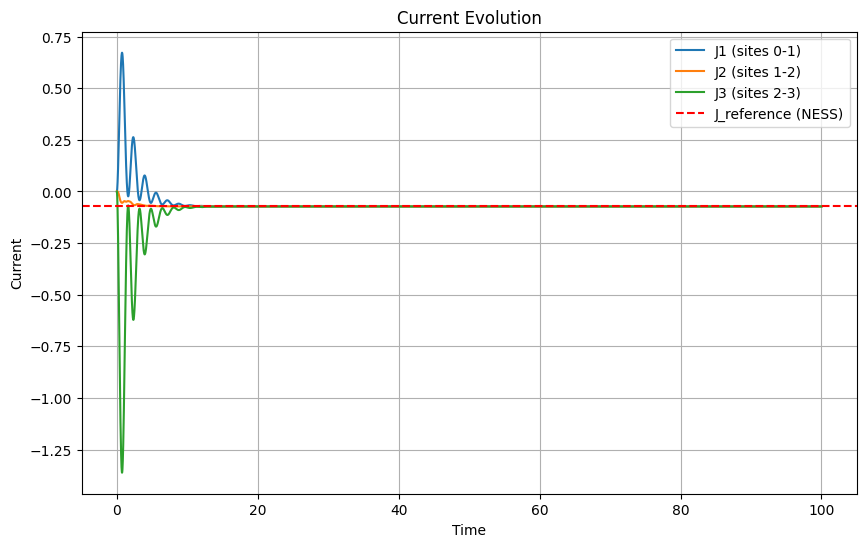

In [4]:

N = 4
import scipy


delta_L_over_J_L = 5.0
J_list = [1, 1, 1]  # J_L = J_R = J_M = 1
delta_list = [delta_L_over_J_L * J_list[0], 0, 0]  # ∆_L = (∆_L/J_L)*J_L

H = Build_Hamiltonian(N, delta_list, J_list)

    # Solve null space and find NESS for forward current case
lambda_1 = 0.5
lambda_N = 0.0

L_K = [np.sqrt(lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
        np.sqrt(1 - lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
        np.sqrt(lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_plus),
        np.sqrt(1 - lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_minus)]

Superoperator = Liouvillian(H, L_K)
null = null_space(Superoperator)
NULL = null[:, 0]
rho_ss = NULL.reshape(2**N, 2**N)
rho_ss = rho_ss / np.trace(rho_ss)

    # Check continuity of currents
J_values = []
for k in range(N-1): 
        Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - 
                                       Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
        J = np.trace(Current_operator@rho_ss)
        J_values.append(J)
    
    # Verify all currents are equal
J_reference = J_values[0]  # Save reference value
print (f"Reference current: {J_reference}")
assert np.allclose(J_values, J_reference), "Something is wrong"
    


up = np.array([1, 0])
down = np.array([0, 1])
state_uuuu = up
for _ in range(3):
    state_uuuu = np.kron(state_uuuu, up)

density_matrix = np.outer(state_uuuu, state_uuuu.conj())

def verify_density_matrix(rho):
    # Check Hermitian
    hermitian = np.allclose(rho, rho.conj().T)
    print(f"Is Hermitian: {hermitian}")
    
    # Check trace is 1
    trace = np.trace(rho)
    print(f"Trace: {trace} (should be 1)")
    
    # Check positive semidefinite?
    eigenvalues = np.linalg.eigvalsh(rho)
    print(f"Eigenvalues: {eigenvalues}")
    print(f"All eigenvalues ≥ 0: {np.all(eigenvalues >= 0)}")
    
    # Check purity 
    purity = np.trace(rho @ rho)
    print(f"Purity (Tr(ρ²)): {purity} (should be 1 for pure state)")

vectorized_dm = density_matrix.reshape(-1)  # Flatten 
normalized_vector = vectorized_dm / np.linalg.norm(vectorized_dm)

dt = 0.01
num_steps = 10000
gamma = 1


# Create time evolution operator
U = scipy.linalg.expm(Superoperator * dt)

rho_t = density_matrix.reshape(-1)  # Vectorized  state

# Time evolution loop
for step in range(num_steps):
    rho_t = U @ rho_t  
    
# Reshape to density matrix 
rho_final = rho_t.reshape(2**N, 2**N)



rho_t = density_matrix.reshape(-1)

J1_history = np.zeros(num_steps)
J2_history = np.zeros(num_steps)
J3_history = np.zeros(num_steps)
time_points = np.arange(num_steps) * dt

# Define current operators for each site
J_operators = [
    2 * J_list[0] * (Correlation_Matrix_i_Matrix_j(0, 1, N, Sigma_x, Sigma_y) - 
                   Correlation_Matrix_i_Matrix_j(0, 1, N, Sigma_y, Sigma_x)),  # J1 between sites 0-1
    2 * J_list[1] * (Correlation_Matrix_i_Matrix_j(1, 2, N, Sigma_x, Sigma_y) - 
                   Correlation_Matrix_i_Matrix_j(1, 2, N, Sigma_y, Sigma_x)),  # J2 between sites 1-2
    2 * J_list[2] * (Correlation_Matrix_i_Matrix_j(2, 3, N, Sigma_x, Sigma_y) - 
                   Correlation_Matrix_i_Matrix_j(2, 3, N, Sigma_y, Sigma_x))   # J3 between sites 2-3
]

# Time evolution loop
for step in range(num_steps):
    rho_t = U @ rho_t
    
    rho_matrix = rho_t.reshape(2**N, 2**N)
    rho_matrix = rho_matrix / np.trace(rho_matrix)
    rho_t = rho_matrix.reshape(-1)
    
    J1_history[step] = np.trace(J_operators[0] @ rho_matrix)
    J2_history[step] = np.trace(J_operators[1] @ rho_matrix)
    J3_history[step] = np.trace(J_operators[2] @ rho_matrix)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, J1_history, label='J1 (sites 0-1)')
plt.plot(time_points, J2_history, label='J2 (sites 1-2)')
plt.plot(time_points, J3_history, label='J3 (sites 2-3)')
plt.axhline(y=J_reference, color='r', linestyle='--', label='J_reference (NESS)')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Evolution')
plt.legend()
plt.grid(True)
plt.show()


In [5]:

N = 6

deltaL_over_JL_values = np.linspace(-8, 8, 30)  # (∆_L/J_L): xaxis of figures


Currents_reverse = np.array([])
Currents_forward = np.array([])

for value in deltaL_over_JL_values:  # (∆_L/J_L)SS

    J_list = [1, 1, 1]  # J_L = J_R = J_M = 1
    delta_list = [value * J_list[0], 0, 0]  # ∆_L = (∆_L/J_L)*J_L

    H = Build_Hamiltonian(N, delta_list, J_list)

    #Reverse Current
    lambda_1 = 0
    lambda_N = 0.5

    L_K = [np.sqrt(lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
           np.sqrt(1 - lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
           np.sqrt(lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_plus),
           np.sqrt(1 - lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)


    null = null_space(Superoperator)  # NESS as a 4^N vector.
    NULL = null[:, 0]  # Take the first vector in the null space.

    #RESHAPE NULL AS A MATRIX AND NORMALIZE IT:
    rho_ss = NULL.reshape(2**N, 2**N)
    rho_ss = rho_ss / np.trace(rho_ss)

    # Define the current operator
    k = 0  # site to calculate current
    Current_operator = 2 * J_list[k] * (Correlation_Matrix_i_Matrix_j(k, k + 1, N, Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k, k + 1, N, Sigma_y, Sigma_x))

    # Calculate and store current
    Current = np.trace(Current_operator @ rho_ss)
    Currents_reverse = np.append(Currents_reverse, Current)

       #Forward Current   
    lambda_1 = 0.5
    lambda_N = 0.0

    L_K = [np.sqrt(lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
           np.sqrt(1 - lambda_1) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
           np.sqrt(lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_plus),
           np.sqrt(1 - lambda_N) * Enlarge_Matrix_site_j(N - 1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)

    # Find the non-equilibrium steady state (NESS)
    null = null_space(Superoperator)
    NULL = null[:, 0]

    # Reshape and normalize
    rho_ss = NULL.reshape(2**N, 2**N)
    rho_ss = rho_ss / np.trace(rho_ss)

    # The current operator is the same
    k = 0 # site to calculate current
    Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
    
    # Calculate and store the current
    Current = np.trace(Current_operator@rho_ss)
    Currents_forward = np.append(Currents_forward, Current)

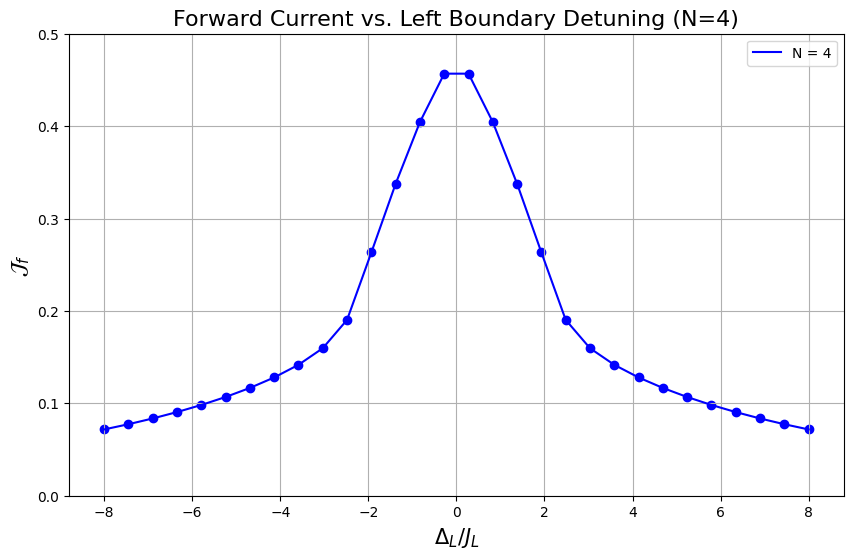

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(deltaL_over_JL_values, np.abs(Currents_forward), label="N = 4", color="blue")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_forward), color="blue")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize=15)
plt.ylabel(r"$\mathcal{J}_{f}$", fontsize=15)
plt.title("Forward Current vs. Left Boundary Detuning (N=4)", fontsize=16)
plt.legend()
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

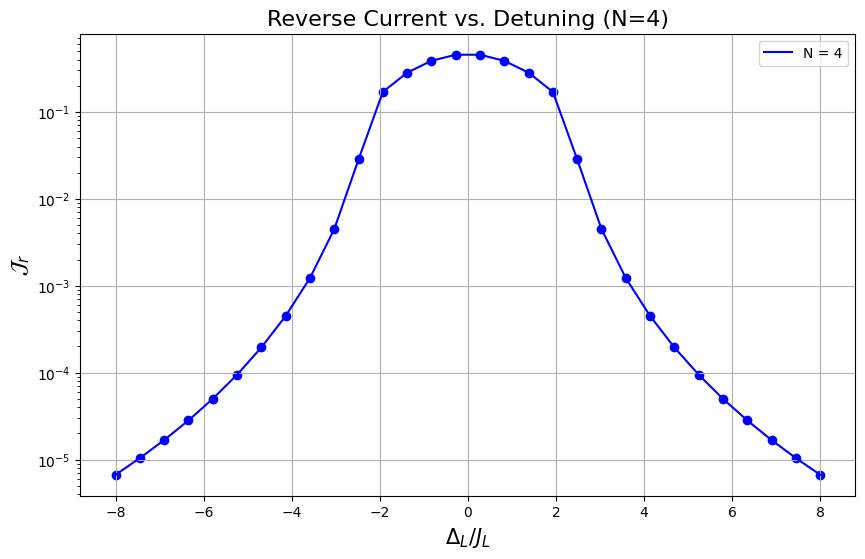

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(deltaL_over_JL_values, np.abs(Currents_reverse), label="N = 4", color="blue")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_reverse), color="blue")
plt.yscale("log")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize=15)
plt.ylabel(r"$\mathcal{J}_{r}$", fontsize=15)
plt.title("Reverse Current vs. Detuning (N=4)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


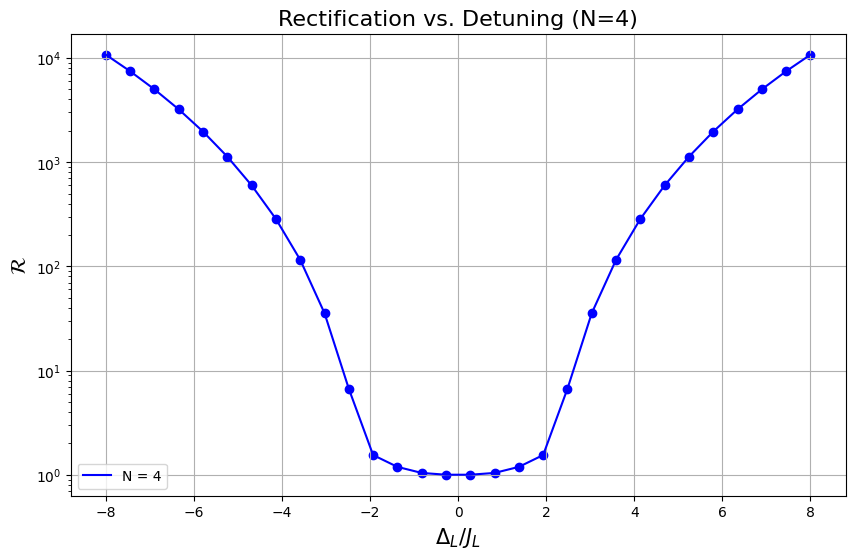

In [8]:
import matplotlib.pyplot as plt
import numpy as np
R_N4 = -Currents_forward / (Currents_reverse)
plt.figure(figsize=(10, 6))
plt.plot(deltaL_over_JL_values, R_N4, label="N = 4", color="blue")
plt.scatter(deltaL_over_JL_values, R_N4, color="blue")
plt.yscale("log")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize=15)
plt.ylabel(r"$\mathcal{R}$", fontsize=15)
plt.title("Rectification vs. Detuning (N=4)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

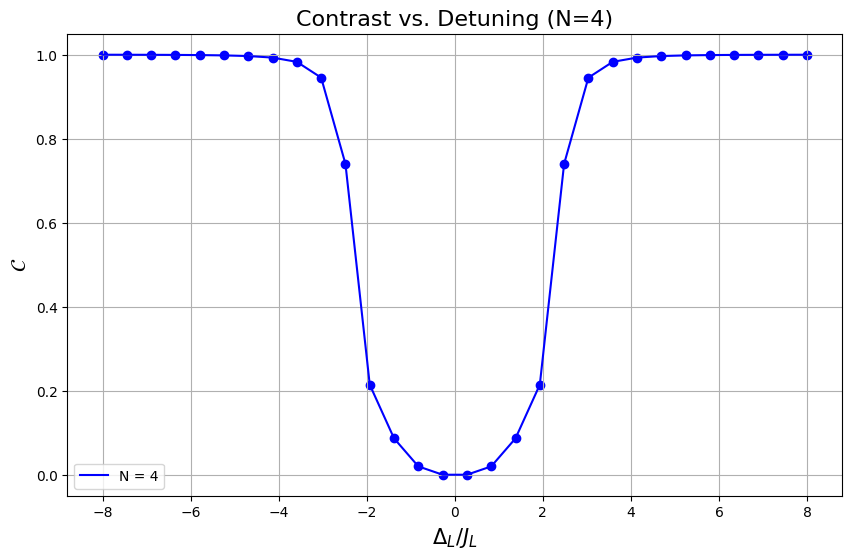

In [9]:
C_N4 = np.abs((Currents_forward + Currents_reverse) / (Currents_forward - Currents_reverse))
plt.figure(figsize=(10, 6))
plt.plot(deltaL_over_JL_values, C_N4, label="N = 4", color="blue")
plt.scatter(deltaL_over_JL_values, C_N4, color="blue")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize=15)
plt.ylabel(r"$\mathcal{C}$", fontsize=15)
plt.title("Contrast vs. Detuning (N=4)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [10]:

##Params

eps = 1
gamma = 1 
mu = 0
T = 100
F = 1 / (1 + np.exp((eps - mu) / T))
# Define Hamiltonian
H = eps*Sigma_minus@Sigma_plus

#Define lindblad operators
L_plus = np.sqrt(gamma*(1-F)) * Sigma_plus
L_minus = np.sqrt(gamma*F) * Sigma_minus

L_K = [L_minus, L_plus] 

numberop = Sigma_minus@Sigma_plus

initial_state = np.matrix([[0.61992668-0.64308201j, 0.15997913-0.05642574j],
             [0.31615777-0.07099076j, 0.24563445+0.08959659j]])


Superoperator = Liouvillian(H, L_K)
null = null_space(Superoperator)
NULL = null[:, 0]
rho_ss = NULL.reshape(2, 2)
rho_ss = rho_ss / np.trace(rho_ss)

referenceN = np.trace(numberop @ rho_ss)
print(f"Reference number operator expectation value: {referenceN}")

verify_density_matrix(rho_ss)
verify_density_matrix(initial_state)

# Create time evolution operator
U = scipy.linalg.expm(Superoperator * dt)
rho_t = initial_state.reshape(4,1)  # Vectorized  state

expectation_value_history = [np.trace(numberop @ initial_state)]
time_points = [0]

# Time evolution loop
for step in range(num_steps):
    rho_t = U @ rho_t
    rho_matrix = rho_t.reshape(2 2)
    rho_matrix = rho_matrix / np.trace(rho_matrix)
    expectation_value_history.append(np.trace(numberop @ rho_matrix))
    time_points.append((step + 1) * dt)


    

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, expectation_value_history, label='Expectation Value')
plt.axhline(y=referenceN, color='r', linestyle='--', label='Reference')
plt.xlabel('Time')
plt.ylabel('Expectation Value of Number Operator')
plt.title('Expectation Value Evolution')
plt.legend()
plt.grid(True)
plt.show()


## Organize code better
## Save data to txt file and compare with Hirad
##Scale the graph better
##Do the slides
##Add more comments
## Create Github  


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2642264543.py, line 45)

N = 4
Sig^+1 --> 

 # H = ∑ I⊗...⊗I⊗JSx⊗Sx⊗I...⊗I + I⊗...⊗I⊗JSy⊗Sy⊗I...⊗I + I⊗...⊗I⊗ΔSz⊗Sz⊗I...⊗I

 ## -i[H,P] +ᵟ(1-F)[σ^^+pσ^^- -1/2{σ^-σ^+,p}] + ᵟF[σpσ^+- 1/2{σ^+σ^-,p}]


 